In [20]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 

In [2]:
IMAGE_SIZE=155
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    'Images/Training',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2870 files belonging to 4 classes.


In [4]:
class_names=dataset.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [5]:
len(dataset)

90

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 155, 155, 3)
[1 0 0 0 3 3 0 3 3 1 1 0 1 3 3 3 0 2 3 1 3 1 0 2 1 1 0 3 0 3 1 1]


2024-09-14 00:52:07.301048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-09-14 00:52:08.062159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


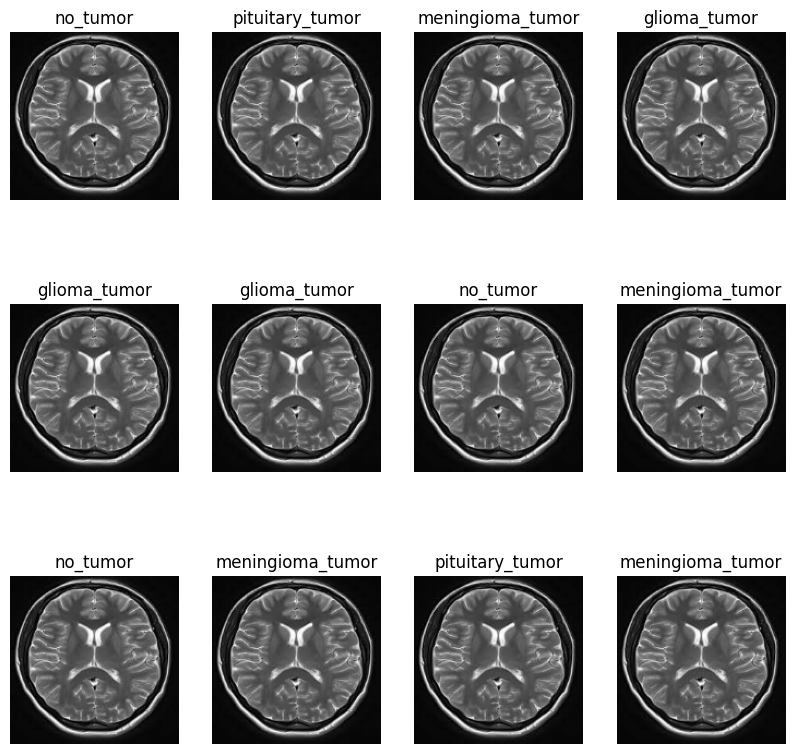

In [7]:
plt.figure(figsize=(10,10))

for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
    

In [8]:
def get_dataset_splts(ds,train_split=0.9,val_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=42)
    train_size=int(train_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size)
    


    return train_ds,val_ds

In [32]:
test_ds=tf.keras.preprocessing.image_dataset_from_directory(
    'Images/Testing',

    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 394 files belonging to 4 classes.


In [10]:
train_ds,val_ds=get_dataset_splts(dataset)

In [11]:
len(train_ds)

81

In [12]:
len(val_ds)

9

In [13]:
len(test_ds)

13

In [14]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)

])

In [16]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
])

In [21]:
input_shape=(IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes=4
model=models.Sequential([
    layers.InputLayer(input_shape=input_shape),  
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128,(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(512,activation='relu'),\
    layers.Dropout(0.5),
    layers.Dense(n_classes,activation='softmax')
])


In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 155, 155, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 155, 155, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 153, 153, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 76, 76, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 35, 35, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,035,716 (72.62 MB)

 Trainable params: 19,035,716 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [24]:
history=model.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1,validation_data=val_ds)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 224s 3s/step - accuracy: 0.4289 - loss: 1.3906 - val_accuracy: 0.5556 - val_loss: 1.0219
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.5562 - loss: 1.0557 - val_accuracy: 0.6181 - val_loss: 0.9024
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.6247 - loss: 0.8893 - val_accuracy: 0.7083 - val_loss: 0.7645
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.6979 - loss: 0.7591 - val_accuracy: 0.6458 - val_loss: 0.7819
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.6952 - loss: 0.7183 - val_accuracy: 0.7396 - val_loss: 0.6626
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.7145 - loss: 0.6796 - val_accuracy: 0.7917 - val_loss: 0.5708
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.7430 - loss: 0.6261 - val_accuracy: 0.8056 - val_loss: 0.5532
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.7435 - loss: 0.5926 - val_accuracy: 0.8194 - v

In [33]:
scores=model.evaluate(test_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 389ms/step - accuracy: 0.4401 - loss: 2.7450


In [26]:
val_acc=history.history['val_accuracy']
acc=history.history['accuracy']

val_loss=history.history['val_loss']
loss=history.history['loss']


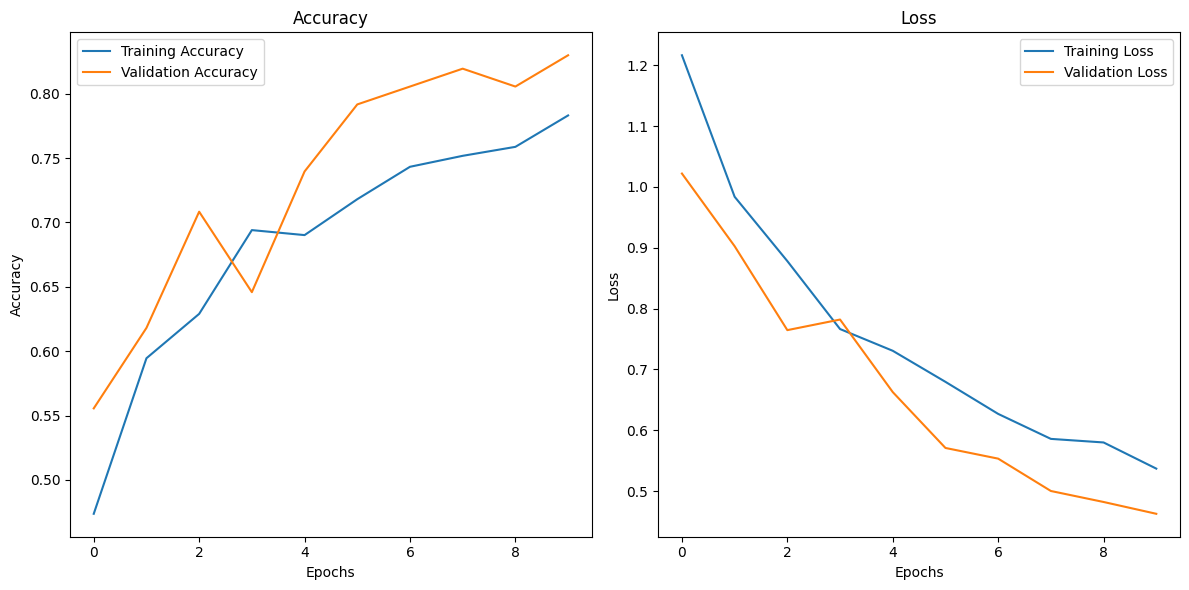

In [27]:
# Create a figure and set of subplots for loss and accuracy
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


first image to predict
first image's actual label: pituitary_tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predicted label: no_tumor


2024-09-14 01:23:07.943612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


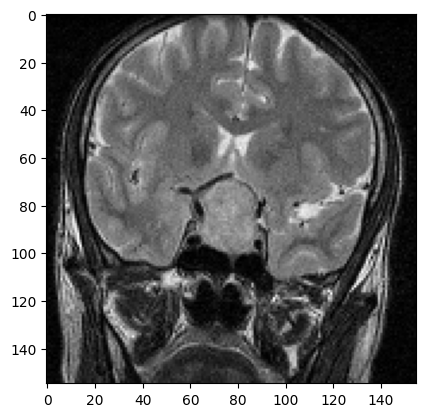

In [28]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()

    print('first image to predict')
    plt.imshow(first_image)
    print('first image\'s actual label:',class_names[first_label])

    batch_pred=model.predict(images_batch)
    print('predicted label:', class_names[np.argmax(batch_pred[0])])

In [29]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0) #creating a batch

    preds=model.predict(img_array)

    predicted_class=class_names[np.argmax(preds[0])]
    confidence=round(100*(np.max(preds[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


2024-09-14 01:23:09.988315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


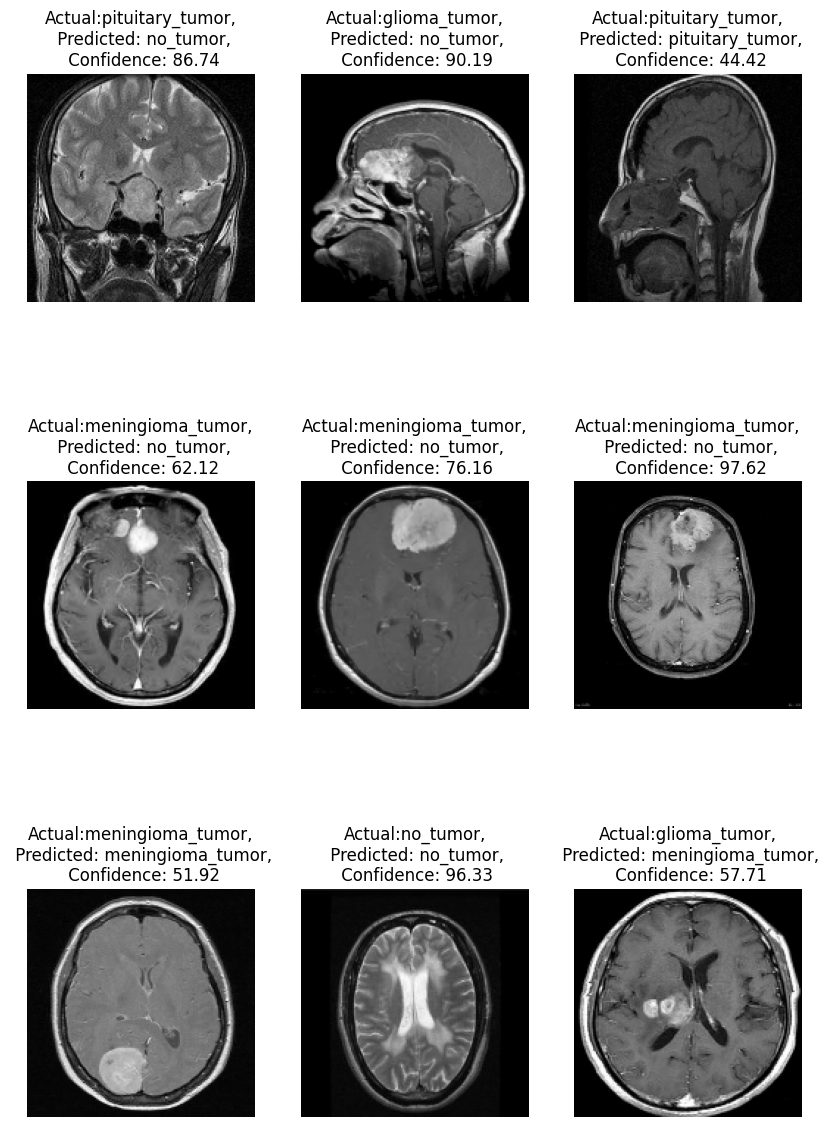

In [30]:
plt.figure(figsize=(10,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence=predict(model, images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f'Actual:{actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}')
        plt.axis('off')

In [35]:
import os

# Filter out non-integer values such as '.DS_Store'
model_version = max([int(i) for i in os.listdir('Models') if i.isdigit()] + [0]) + 1

# Now export the model with the correct version number
model.export(f'Models/{model_version}')


INFO:tensorflow:Assets written to: Models/2/assets


INFO:tensorflow:Assets written to: Models/2/assets


Saved artifact at 'Models/2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 155, 155, 3), dtype=tf.float32, name='keras_tensor_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  4939849296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4939849488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4940720528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4940722064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4940721680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4940722448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4940722256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4940720720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4940722832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4940723408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4940723600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  49407